# Implementing batch input function for loading dataset from local TFRecords, the batch can be used for training and testing based on the batch size

In [1]:
import threading
import numpy as np
import tensorflow as tf

def read_and_decode_single_example(filename):
  # Construct the filename queue
  filename_queue = tf.train.string_input_producer(filename, num_epochs=None, shuffle=True)
  # declare the reader
  reader = tf.TFRecordReader()
  # Reader read the file from file_queue
  _,serialized_example = reader.read(filename_queue)
  # decode the TFRecords file based on defined features in protocol buffer
  features = tf.parse_single_example(
    serialized_example,
    features = {
      'image/encoded': tf.FixedLenFeature([], tf.string), # image decoding
      'image/class/label': tf.FixedLenFeature([], dtype=tf.int64,# label decoding as integer, then be convert to float later
                                              default_value=1)
        })
  image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
#   image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
  image.set_shape([480,640,3]) #has to set the size of the image tensor
  label = tf.cast(features['image/class/label'], tf.float32)
  label = label /100000
  return image,label


def train_batch_input(filenames, batchSize=10, num_preprocess_threads=4, min_queue_size=1024):
# batchSize = 10
  img_width = 480
  img_height = 640
  img_channel = 3
#   filenames = tf.train.match_filenames_once("train_data/*", name=None)
  image,label = read_and_decode_single_example(filenames)

  image_batch, label_batch = tf.train.shuffle_batch(
    [image, label],
    batch_size=batchSize,
    num_threads=num_preprocess_threads,
    capacity=min_queue_size + 3 * batchSize,
    min_after_dequeue=min_queue_size)
  return image_batch, label_batch

# define parameters here
global trainBatchSize
global num_preprocess_threads
global min_queue_size
trainBatchSize = 64
num_preprocess_threads=4
min_queue_size=1024

filenames = tf.train.match_filenames_once("train_data/*", name=None)

single_image, single_label = read_and_decode_single_example(filenames)

image_batch,label_batch = train_batch_input(filenames, batchSize=trainBatchSize,
                                      num_preprocess_threads=num_preprocess_threads, 
                                      min_queue_size=min_queue_size)

In [2]:
# setup the session
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
threads = tf.train.start_queue_runners(sess=sess)


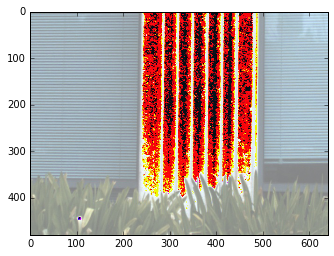

In [ ]:
# load data one by one, the data will be load sequentially based on which TFRecord file the system chose
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
  img,lab = sess.run([single_image,single_label])
  pl.imshow(img)
  display.clear_output(wait=True)
  display.display(pl.gcf())
  time.sleep(.1)

In [3]:
#load data by batch, because this used tf.train.shuffle_batch, it will load data randomly
# here it shows that one batch of the data is loaded in correct pipeline fashion, the print out shows the speed of loading a batch of 64 images with image size of 480 x 640 x 3

%matplotlib inline
import time
import pylab as pl
from IPython import display


for j in range(10):
  time1 = time.time()
  img,lab = sess.run([image_batch,label_batch])
  print (time.time() - time1,"seconds spend to load one batch")
  print (img.shape)

(0.7194979190826416, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.13723015785217285, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.144118070602417, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.13964605331420898, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.15061187744140625, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.12441492080688477, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.11941194534301758, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.11898398399353027, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.1171407699584961, 'seconds spend to load one batch')
(64, 480, 640, 3)
(0.1630089282989502, 'seconds spend to load one batch')
(64, 480, 640, 3)


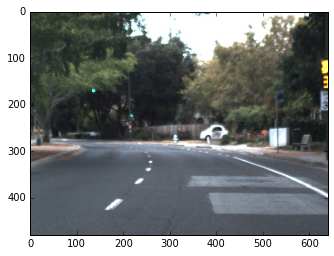

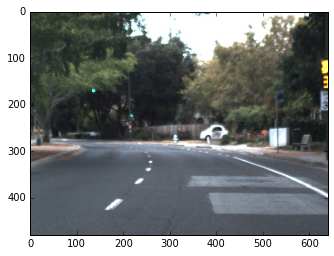

In [5]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
# here is an example showing the loaded randomly
for j in range(30):
  img,lab = sess.run([image_batch,label_batch])
  for i in range(img.shape[0]):
#   for i in range(5):
    pl.imshow(img[i,:,:,:])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.1)